In [1821]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import TransformerMixin
import re
import string
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [1474]:
df_reddit = pd.read_csv('./data/df_reddit.csv')

In [1475]:
df_reddit.shape

(2029, 9)

In [1476]:
df_reddit.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,"Free market capitalism, I’m Gen Z and honestly...",[removed],investing,1584573611,KellyCriterionHedged,13,0,True,2020-03-18
1,Tell me why I shouldn’t purchase a substantial...,[deleted],investing,1584573629,[deleted],10,1,True,2020-03-18
2,Can my 401k retirement account trigger a wash ...,Hypothetical scenario:\n\nI am looking to sell...,investing,1584573685,philosophytautology,9,0,True,2020-03-18
3,GILD.. The DD is in the link... FDA message to...,\n\nThe DD is in the link.. Why the fuck shou...,investing,1584573694,TawALittlePuttyTat,2,0,True,2020-03-18
4,Good time to invest?,Do y'all think there will be a raise in the ma...,investing,1584573941,rcmiddle,10,0,True,2020-03-18


In [1477]:
df_reddit.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
2024,Late 30's with 14 month old twins...,"Hi there, we are seeing a financial advisor en...",Bogleheads,1532267202,goldy740,4,12,True,2018-07-22
2025,Moving money from American Funds. I need help ...,[removed],Bogleheads,1532308550,smithfoam,0,1,True,2018-07-22
2026,$10k to invest - Need guidance,Hi - I had been depositing $100 every month in...,Bogleheads,1532365928,suzukiaquarian1,10,4,True,2018-07-23
2027,401k Advice,My plan right now is to go 100% stocks: 60% US...,Bogleheads,1532370877,neonbeanbag,5,5,True,2018-07-23
2028,401k Vanguard allocation advice (newbie),Apologies in advance for my very newbie questi...,Bogleheads,1532548204,aegyo_bae,9,6,True,2018-07-25


In [1478]:
df_reddit.isnull().sum()

title            0
selftext        83
subreddit        0
created_utc      0
author           0
num_comments     0
score            0
is_self          0
timestamp        0
dtype: int64

In [1479]:
#fill null values with empty strings. Will add selftext and text columns together
df_reddit.selftext.fillna(value='', inplace=True)

In [1482]:
#Transform target variable into a binary category r/Investing will be 1 and r/Bogleheads will be 0. 
df_reddit['target']= df_reddit['subreddit'].map({'investing': 1, 'Bogleheads':0})

In [1483]:
#drop column subreddit now that we have created a new column 'target' which will be the y variable. 
df_reddit.drop('subreddit', axis = 1, inplace = True)

In [1484]:
df_reddit.shape

(2029, 9)

In [1485]:
#drop columns that will not be used in our model. The most pertinent information for our goal of predicting subreddits
#comes from columns title and selftext 
df_reddit.drop(columns =['created_utc', 'author', 'num_comments', 'score', 'is_self',
                         'timestamp'], axis = 1, inplace = True)

In [1486]:
df_reddit.shape

(2029, 3)

In [1666]:
#check value counts of the subreddits. We have balanced classes.
df_reddit['target'].value_counts(normalize = True)

0    0.509154
1    0.490846
Name: target, dtype: float64

In [1488]:
#Check for duplicates in our subreddit posts. 
df_reddit.duplicated().sum()

8

In [1489]:
df_reddit[df_reddit.duplicated(['title'])] [['selftext', 'title']].sort_values(by='title')

,selftext,title
497,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
550,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
696,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
856,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
226,How to calculate stock profit i tought i knew ...,Help
229,How to calculate stock profit i tought i knew ...,Help
671,I just got my fidelity account set up and I do...,Investing
1611,"Hi guys,\n\nI recently opened a Roth account (...",Investing
562,[removed],Pi Network Cryptocurrency
619,[removed],Pi Network Cryptocurrency


In [1490]:
df_reddit.isnull().sum()

title       0
selftext    0
target      0
dtype: int64

In [1491]:
df_reddit.dropna(inplace = True)

In [1492]:
df_reddit.drop_duplicates(inplace = True)

In [1493]:
df_reddit.shape

(2021, 3)

In [1494]:
df_reddit.duplicated().sum()

0

In [1495]:
df_reddit.isnull().sum()

title       0
selftext    0
target      0
dtype: int64

In [1496]:
df_reddit.head()

,title,selftext,target
0,"Free market capitalism, I’m Gen Z and honestly...",[removed],1
1,Tell me why I shouldn’t purchase a substantial...,[deleted],1
2,Can my 401k retirement account trigger a wash ...,Hypothetical scenario:\n\nI am looking to sell...,1
3,GILD.. The DD is in the link... FDA message to...,\n\nThe DD is in the link.. Why the fuck shou...,1
4,Good time to invest?,Do y'all think there will be a raise in the ma...,1


In [ ]:
#Text data (also called natural language data) is not already organized as a matrix or vector of real numbers. 
#We say that this data is unstructured.

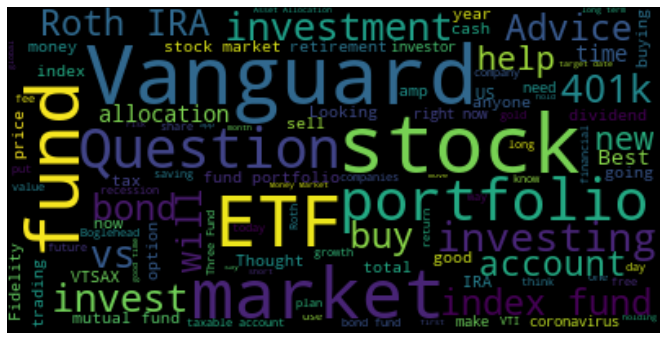

In [1497]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(' '.join(df_reddit['title']))

# Display the generated image:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

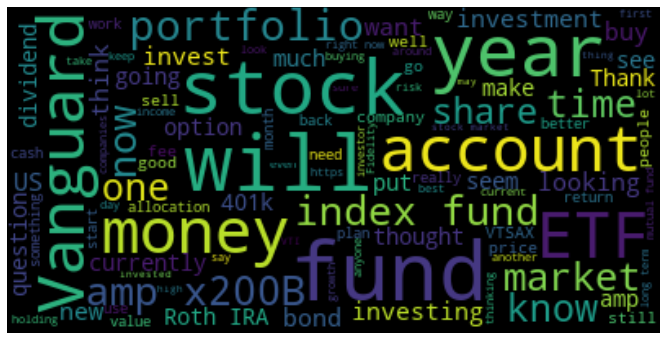

In [1649]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(' '.join(df_reddit['selftext']))

# Display the generated image:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [1498]:
df_reddit['features'] = df_reddit['title'] + ' ' + df_reddit['selftext']

In [1499]:
df_reddit.head()

,title,selftext,target,features
0,"Free market capitalism, I’m Gen Z and honestly...",[removed],1,"Free market capitalism, I’m Gen Z and honestly..."
1,Tell me why I shouldn’t purchase a substantial...,[deleted],1,Tell me why I shouldn’t purchase a substantial...
2,Can my 401k retirement account trigger a wash ...,Hypothetical scenario:\n\nI am looking to sell...,1,Can my 401k retirement account trigger a wash ...
3,GILD.. The DD is in the link... FDA message to...,\n\nThe DD is in the link.. Why the fuck shou...,1,GILD.. The DD is in the link... FDA message to...
4,Good time to invest?,Do y'all think there will be a raise in the ma...,1,Good time to invest? Do y'all think there will...


In [1501]:
df_y.shape

(2021,)

In [1502]:
def clean_str(string):
    string = string.lower()
    #string = re.sub(r'https?:\/\/.*\/\w*', '', string)
    url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
    string = re.sub(url_pattern, ' ', string)
    string = re.sub(r"\n", "", string)    
    string = re.sub(r"\r", "", string) 
    string = re.sub(r"[2-3,5-9]+", "", string)
    string = re.sub(r'[^\w\s]','', string)    
    #string = re.sub(r"\"", "", string) 
    #string = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', string)
    
    return string.strip()

In [1503]:
df_reddit['features'] = df_reddit['features'].map(clean_str)

In [1504]:
df_reddit.tail()

,title,selftext,target,features
2024,Late 30's with 14 month old twins...,"Hi there, we are seeing a financial advisor en...",0,late 0s with 14 month old twins hi there we ar...
2025,Moving money from American Funds. I need help ...,[removed],0,moving money from american funds i need help d...
2026,$10k to invest - Need guidance,Hi - I had been depositing $100 every month in...,0,10k to invest need guidance hi i had been de...
2027,401k Advice,My plan right now is to go 100% stocks: 60% US...,0,401k advice my plan right now is to go 100 sto...
2028,401k Vanguard allocation advice (newbie),Apologies in advance for my very newbie questi...,0,401k vanguard allocation advice newbie apologi...


In [1505]:
from nltk.stem import PorterStemmer 

In [1701]:
lemmatizer = WordNetLemmatizer()

In [1702]:
lemmatizer.lemmatize('jumping')

'jumping'

In [1508]:
def func(text):                       
    return [lemmatizer.lemmatize(word) for word in text.split()]
                        
df_reddit['features'].map(func)

0       [free, market, capitalism, im, gen, z, and, ho...
1       [tell, me, why, i, shouldnt, purchase, a, subs...
2       [can, my, 401k, retirement, account, trigger, ...
3       [gild, the, dd, is, in, the, link, fda, messag...
4       [good, time, to, invest, do, yall, think, ther...
                              ...                        
2024    [late, 0, with, 14, month, old, twin, hi, ther...
2025    [moving, money, from, american, fund, i, need,...
2026    [10k, to, invest, need, guidance, hi, i, had, ...
2027    [401k, advice, my, plan, right, now, is, to, g...
2028    [401k, vanguard, allocation, advice, newbie, a...
Name: features, Length: 2021, dtype: object

In [1665]:
df_reddit.head()

,title,selftext,target,features
0,"Free market capitalism, I’m Gen Z and honestly...",[removed],1,free market capitalism im gen z and honestly i...
1,Tell me why I shouldn’t purchase a substantial...,[deleted],1,tell me why i shouldnt purchase a substantial ...
2,Can my 401k retirement account trigger a wash ...,Hypothetical scenario:\n\nI am looking to sell...,1,can my 401k retirement account trigger a wash ...
3,GILD.. The DD is in the link... FDA message to...,\n\nThe DD is in the link.. Why the fuck shou...,1,gild the dd is in the link fda message tomorro...
4,Good time to invest?,Do y'all think there will be a raise in the ma...,1,good time to invest do yall think there will b...


In [1800]:
words_cape = words
words_count_cape = cv_train_small.loc[1]
words_gv = words
words_count_gv = cv_train_small.loc[0]
width = 0.35       # the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(15, 10))
df_reddit['features'] = ax.bar(ind, words_count_cape, width, color=colors[0])
#rects2 = ax.bar(ind+width,words_count_gv, width, color=colors[5])

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_title('Counts by word and reddit')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(words,rotation='vertical')

ax.set_ylim(0,80)

ax.legend((rects1[0], rects2[0]), ('Cape Cod', 'Galveston'))

plt.show()

NameError: name 'words' is not defined

In [ ]:
#Count: Count up how many times a token is observed in a given document.
#Vectorizer: Create a column (also known as a vector) that stores those counts.
#Bag-of-words representations discard grammar, order, and structure in the text but track occurrences.
#For example, CountVectorizer creates a vector (column) for each token and counts up the number of occurrences of 
#each token in each document.

CountVectorizer

In [1727]:
# Instantiate CountVectorizer. At this point in EDA we will use this to get top word counts from each of the subreddits.
cv = CountVectorizer(analyzer = 'word',
                             tokenizer= None ,
                             preprocessor = None ,
                             stop_words = 'english',
                             max_features = 1000,
                             ngram_range = (1,2))


In [1728]:
#create variable for target 1, r/investing for word count analysis 
investing = df_reddit[df_reddit['target'] == 1]['features']

In [1729]:
# fit_transform() does two things: First, it fits the model and 
# learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a 
# list of strings.

# Fit CountVectorizer to target data investing 
investing_words = cv.fit_transform(investing)

In [1730]:
#Transform r/investing data based on the fit CountVectorizer 
investing_words = cv.transform(investing)

In [1731]:
# Create a DataFrame with our words.
top_investing_words = pd.DataFrame(investing_words.todense(), columns = cv.get_feature_names() )

In [1732]:
top_investing_words.sum().sort_values(ascending = False).head()

market    414
im        341
stock     333
like      282
stocks    269
dtype: int64

In [1734]:
bogleheads = df_reddit[df_reddit['target'] == 0]['features']

In [1735]:
bolge_words = cv.fit_transform(bogleheads)

In [1736]:
bolge_words = cv.transform(bogleheads)

In [1737]:
top_bogle_words = pd.DataFrame(bolge_words.todense(), columns = cv.get_feature_names() )

In [1738]:
top_bogle_words.sum().sort_values(ascending = False).head(50)

fund             990
funds            736
im               699
vanguard         691
index            615
market           482
account          472
portfolio        457
just             425
ira              419
roth             393
money            392
like             349
401k             328
00               304
years            300
total            293
year             277
investing        276
retirement       273
bond             261
bonds            255
stock            252
time             252
tax              244
vtsax            238
stocks           230
want             230
allocation       224
invest           223
index fund       216
roth ira         216
know             216
taxable          215
dont             211
target           208
international    205
accounts         198
ive              190
buy              190
dtype: int64

In [1739]:
top_20_bogle = top_bogle_words.sum().sort_values().tail(20)

In [1740]:
top_20_investing = top_investing_words.sum().sort_values().tail(20)

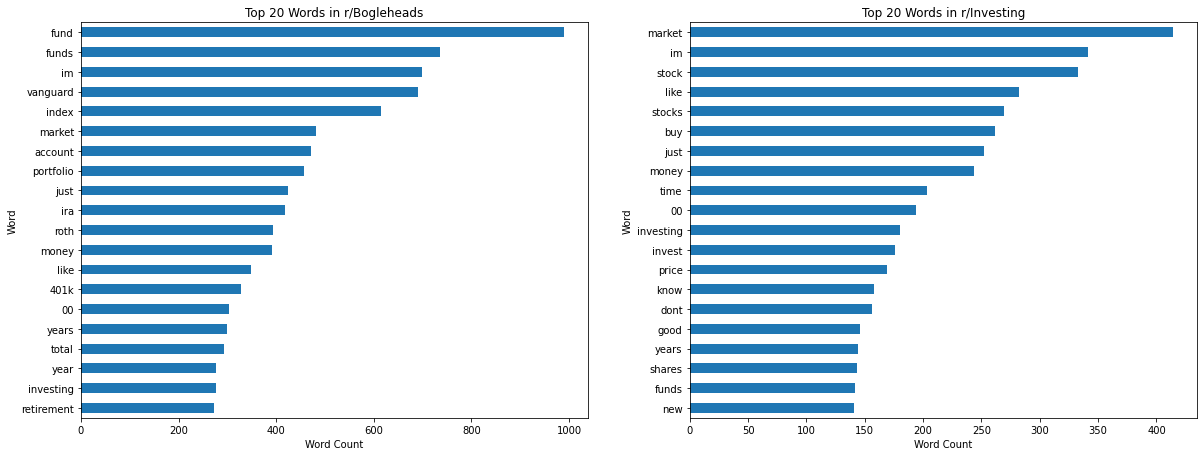

In [1741]:
plt.figure(figsize=(20,16))

plt.subplot(2,2,1)
top_20_bogle.plot(kind='barh')
plt.title('Top 20 Words in r/Bogleheads')
plt.xlabel('Word Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
top_20_investing.plot(kind='barh')
plt.title('Top 20 Words in r/Investing')
plt.xlabel('Word Count')
plt.ylabel('Word');


In [1647]:
#TF-IDF is a score that tells us which words are important to one document, relative to all other documents. 
#Words that occur often in one document but don't occur in many documents contain more predictive power.

In [1742]:
#Instantiate TFIDFVectorizer 
tvec = TfidfVectorizer(analyzer = "word", 
                     stop_words = 'english', 
                     max_features = 1000, 
                     ngram_range = (1, 2))

In [1743]:
investing_words_tvec = tvec.fit_transform(investing)

In [1744]:

investing_words_tvec = tvec.transform(investing)

In [1745]:
investing_words_tvec = pd.DataFrame(investing_words_tvec.todense(), columns = tvec.get_feature_names() )

In [1746]:
investing_words_tvec.sum().sort_values(ascending = False).head(50)

removed        40.936432
market         31.517345
stocks         30.812188
stock          30.210936
im             28.880766
buy            26.693138
like           23.256084
just           21.736442
money          20.970890
investing      20.794358
invest         20.517481
time           19.257560
00             18.737577
thoughts       18.217223
new            17.911530
good           17.503596
think          16.681437
price          16.427717
going          16.302974
right          16.030823
know           15.597060
company        15.592469
best           15.510997
dont           15.127141
looking        14.806650
trading        14.690392
funds          14.684460
account        14.563215
people         14.187278
shares         14.093993
long           13.307248
ive            13.141858
year           12.781988
companies      12.755631
buying         12.754563
portfolio      12.741130
coronavirus    12.572096
etf            12.424670
make           12.421215
investment     12.386947


In [1748]:
bolge_words_tvec = tvec.fit_transform(bogleheads)

In [1749]:
bolge_words_tvec = tvec.transform(bogleheads)

In [1750]:
top_bogle_words_tvec = pd.DataFrame(bolge_words_tvec.todense(), columns = tvec.get_feature_names() )

In [1751]:
top_bogle_words_tvec.sum().sort_values(ascending = False).head(50)

fund             52.793090
vanguard         44.571144
funds            43.201516
im               39.951607
index            38.147992
portfolio        34.185611
market           33.490714
ira              32.860592
roth             31.857794
account          31.842066
money            28.696908
just             27.920455
removed          26.703789
401k             26.499134
like             25.082407
vtsax            22.130124
investing        21.751010
00               21.748846
time             21.316954
years            21.280583
invest           21.114935
year             21.058308
retirement       20.945304
bond             20.753798
buy              20.650453
bonds            20.464707
roth ira         20.208003
tax              19.939010
total            19.819030
etf              19.718583
allocation       18.904410
stocks           18.661383
want             18.566184
know             18.562231
taxable          18.310037
stock            18.293858
index fund       18.162253
l

In [1753]:
stopwords = nltk.corpus.stopwords.words('english')
reddit_stop_words = ['ive', '00', 'im', 'just', 'know', 'like', 'does', 'dont', 'like', 'removed',]
stopwords.extend(reddit_stop_words)
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [1754]:
y = df_reddit['target']
X = df_reddit['features']

In [1755]:
y.value_counts(normalize = True)

0    0.509154
1    0.490846
Name: target, dtype: float64

## Test Train Split

In [1611]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state = 42)

In [1756]:
#Baseline model 
y_train.value_counts(normalize = True)

0    0.508911
1    0.491089
Name: target, dtype: float64

# Modeling

In [1773]:
#Logistic Regression Model w/ CountVectorizer
pipe_cv = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

#Grid Parameters
pipe_params = {'cvec__max_features': [500, 1000, 1500],
              'cvec__stop_words': [stopwords, None], 
               'cvec__ngram_range': [(1,1), (1,2)]} #ngram range set to default and (1,2) 

In [1774]:
 # Perform Grid Search
gs = GridSearchCV(pipe_cv, # pipeline object replaces what we usually had as empty model class
                 pipe_params,
                 cv=5)

In [1775]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [1776]:
print(gs.best_score_) 
gs.best_params_

0.8138613861386138


{'cvec__max_features': 1000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in

In [1770]:
#Ran the logistic Regression model again with no stopwords to observe the difference in score from the LR model w/
# stopwords. 
pipe_params1 = {'cvec__max_features': [1000,1500,],
              'cvec__stop_words': [None], 
               'cvec__ngram_range': [(1,1), (1,2)]}

gs1 = GridSearchCV(pipe_cv,
                 pipe_params1,
                 cv=5)

In [1771]:
gs1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [1772]:
print(gs1.best_score_) 
gs1.best_params_

0.7973597359735973


{'cvec__max_features': 1500,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

Model scores slightly better (+1.5%) when using the udpated list of stopwords in comparsion to the this LR model that does not take into account stopwords. 

In [1789]:
#Logistic Regression Model w/ TFIDFVectorizer
pipe_tf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])


pipe_params_tf = {'tvec__max_features': [500, 1000, 1500], #max features 
              'tvec__stop_words': [stopwords, None], #customized stopwords list and no stopwords 
               'tvec__ngram_range': [(1,1), (1,2)]}

In [1790]:
gs_tf = GridSearchCV(pipe_tf, 
                     pipe_params_tf, 
                     cv=5)

In [1791]:
gs_tf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [1792]:
#max features 1,000 n_gram range (1,2) 
print(gs_tf.best_score_) 
gs_tf.best_params_

0.8402640264026403


{'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in

## GaussianNB model

In [1810]:
#Referenced from dsi_11 FAQ
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [1812]:
cvec_gnb = [
    ("cvec", CountVectorizer()),
    ("dense", DenseTransformer()),
    ("gauss", GaussianNB())
]

cvec_paramsgnb = {
    'cvec__max_features': [500, 1000 , 1500],
    'cvec__ngram_range': [(1,2), (1,1)],
    'cvec__stop_words': [None, 'english', stopwords]}


pipegnb = Pipeline(cvec_gnb)

In [1813]:
cvec_guasNB = GridSearchCV(pipegnb, cvec_paramsgnb, cv = 5)

In [1814]:
cvec_guasNB.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [1815]:
cvec_guasNB.score(X_train, y_train)

0.8442244224422443

In [1819]:
y_pred = cvec_guasNB.predict(X_test)


In [1824]:
pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns=['predict /r/Bogleheads', 'predict /r/Investing'],
            index=['actual /r/Bogleheads', 'actual /r/Investing'])

,predict /r/Bogleheads,predict /r/Investing
actual /r/Bogleheads,175,83
actual /r/Investing,27,221


In [1795]:
tf = TfidfVectorizer()

tf.fit(X_train, y_train)

X_train_tf = tf.transform(X_train).todense()
X_test_tf = tf.transform(X_test).todense()

In [1796]:
gnb = GaussianNB()

In [1797]:
gnb.fit(X_train_tf, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [1799]:
print(gnb.score(X_train_tf, y_train))

0.9623762376237623


In [1804]:
cvgb = CountVectorizer()

In [1805]:
cvgb.fit(X_train, y_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [1806]:
X_train_cv = cvgb.transform(X_train).todense()
X_test_cv = cvgb.transform(X_test).todense()

In [1807]:
gnb.fit(X_train_cv, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [1808]:
gnb.score(X_train_cv, y_train)

0.9379537953795379

In [ ]:
cvec_params = {
    'cvec__max_features': [100,500],
    'cvec__ngram_range': [(1,2), (1,1)],
    'cvec__stop_words': [None, "english"]}



pipe = Pipeline(cvec_gnb)

cvec_guasNB = GridSearchCV(pipe, cvec_params, cv = 5)

In [1801]:
mnb = MultinomialNB()

In [1803]:
mnb.fit(X_train, y_train).predict(X_test)

ValueError: could not convert string to float: 'sorry for my dumb question on dividends quoted vtsax shows its 101 dividend as    does that mean   of the value of the shares owned is paid as the dividend or does it mean   is paid out per share owned'

In [1424]:
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)

In [1426]:
accuracy_score(y_test, y_pred)

0.7578253706754531

In [1427]:
y_pred = GaussianNB().fit(X_train, y_train).predict(X_test)

In [1428]:
accuracy_score(y_test, y_pred)

0.7232289950576606

In [1433]:
from sklearn.linear_model import LogisticRegression

In [1435]:
y_pred = LogisticRegression().fit(X_train, y_train).predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


In [1436]:
accuracy_score(y_test, y_pred)

0.8088962108731467